In [22]:
import json
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import mplhep as mh

from hist.hist import Hist
from hist.axis import Regular
from hist.axis import IntCategory
from hist.axis import StrCategory

from pathlib import Path

from typing import Optional, Union

In [23]:
from functools import cache
from functools import cached_property

@cache
def get_segment(ring: int, station: int, sector: int, subsector: int) -> int:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L361-L368
    """
    nsub = 3 if ring == 1 and station > 1 else 6
    return subsector + nsub * (sector - 1)


@cache
def get_roll_name(region: int, ring: int, station: int, sector: int, layer: int,
             subsector: int, roll: int
) -> str:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L11-L87
    """
    if region == 0:
        name = f'W{ring:+d}_RB{station}'

        if station <= 2:
            name += 'in' if layer == 1 else 'out'
        else:
            if sector == 4 and station == 4:
                name += ['--', '-', '+', '++'][subsector - 1]
            elif (station == 3) or (station == 4 and sector not in (4, 9, 11)):
                name += '-' if subsector == 1 else '+'
        name += f'_S{sector:0>2d}_'
        name += ['Backward', 'Middle', 'Forward'][roll - 1]
    else:
        segment = get_segment(ring, station, sector, subsector)
        name = f'RE{station * region:+d}_R{ring}_CH{segment:0>2d}_'
        name += ['A', 'B', 'C', 'D', 'E'][roll - 1]
    return name

In [24]:
def load_data(input_path: Path,
                       roll_blacklist_path: Optional[Path] = None,
)->dict:
    data = uproot.open(f"{str(input_path)}:tree").arrays(library='np')

    if roll_blacklist_path is None:
        roll_blacklist = set()
    else:
        with open(roll_blacklist_path) as stream:
            roll_blacklist = set(json.load(stream))

    fiducial_mask = data['is_fiducial']

    for key, values in data.items():
        data[key] = data[key][fiducial_mask]

    data['roll_name'] = np.array([get_roll_name(
                                                data['region'][idx], data['ring'][idx], data['station'][idx],
                                                data['sector'][idx], data['layer'][idx], data['subsector'][idx], data['roll'][idx]) 
                                                for idx in range(len(data['region']))])
                                            
    is_blacklist = np.vectorize(lambda item: item in roll_blacklist)
    blacklist_mask = is_blacklist(data['roll_name'])

    for key, values in data.items():
        data[key] = data[key][~blacklist_mask]

    return data

In [12]:
working_dir = Path('/users/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/TnP_Plotting')

data = load_data(
    input_path = working_dir / 'data' / 'Muon__Run2022C.root',
    roll_blacklist_path = working_dir / 'blacklist' / 'roll-blacklist.json',
)

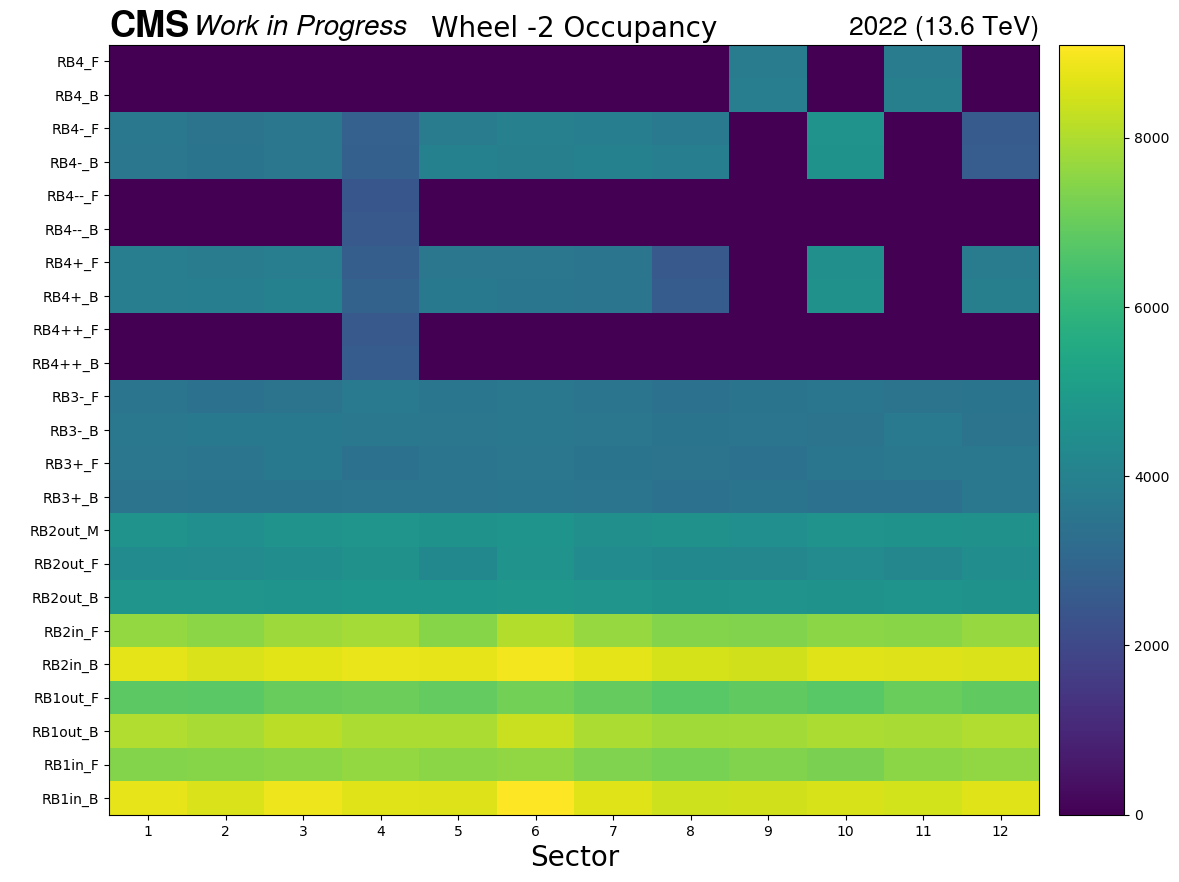

In [65]:
for wheel in ['W-2', 'W-1', 'W+0', 'W+1', 'W+2']:
    is_region = np.vectorize(lambda item: item.startswith(wheel))
    region_mask = is_region(data['roll_name'])
    region_data = {}
    for key, values in data.items():
        region_data[key] = data[key][region_mask]

    fix_roll_name = np.vectorize(lambda item: f"{item.split('_')[1]}_{item.split('_')[3][0]}")
    region_data['fixed_roll_name'] = fix_roll_name(region_data['roll_name'])

    sector_axis = IntCategory(np.unique(region_data['sector']), name='sector')
    fixed_roll_name_axis = StrCategory(np.unique(region_data['fixed_roll_name']), name=' ')

    occupancy2d = Hist(sector_axis, fixed_roll_name_axis)
    occupancy2d.fill(region_data['sector'], region_data['fixed_roll_name'])
    
    fig, ax = plt.subplots(figsize=(12, 10))
    label = "Work in Progress"
    com = 13.6
    mh.cms.label(ax=ax, data=True, label=label, com=com, year="2022", fontsize=20)
    ax.set_xlabel('Sector', fontsize=20)
    ax.set_title("Wheel -2 Occupancy", fontsize=20)

    mh.hist2dplot(
        occupancy2d,
        ax=ax,
        flow=None,
    )
    break


In [137]:
def plot_cls_hist(data: dict,
                           ax: Optional[plt.Axes] = None,
                           facecolor: str = "#d3f5e4",
                           edgecolor: str = "#007700",
                           data_legend: str = "2022",
                           region: str = "all",
                           hatch = None
):
    region = 'barrel'
    if region == "all":
        is_region = np.vectorize(lambda item: type(item) is str)
    elif region == "barrel":
        is_region = np.vectorize(lambda item: item.startswith('W'))
    elif region == "endcap":
        is_region = np.vectorize(lambda item: item.startswith('RE'))
    
    region_mask = is_region(data['roll_name'])
    cls_mask = data['cls'] > 0
    
    for key, values in data.items():
        data[key] = data[key][region_mask & cls_mask]    
    
    hist, bins = np.histogram(data['cls'], bins=11, range=(0, 11))
    mh.histplot(
        hist,
        bins=bins - 0.5,
        ax=ax,
        yerr = False,
        histtype="fill",
        facecolor=facecolor,
        edgecolor=edgecolor,
        linewidth=1.6,
        flow=None,
        label=f"{data_legend}        {np.mean(data['cls']) : .1f}\t ",
        alpha=0.5,
        hatch=hatch,
        density=True,
    )
    return ax

/tmp/ipykernel_56887/1486189497.py:41: UserWarning: Glyph 9 (	) missing from current font.
  fig.savefig(output_dir / "run3-barrel.png")


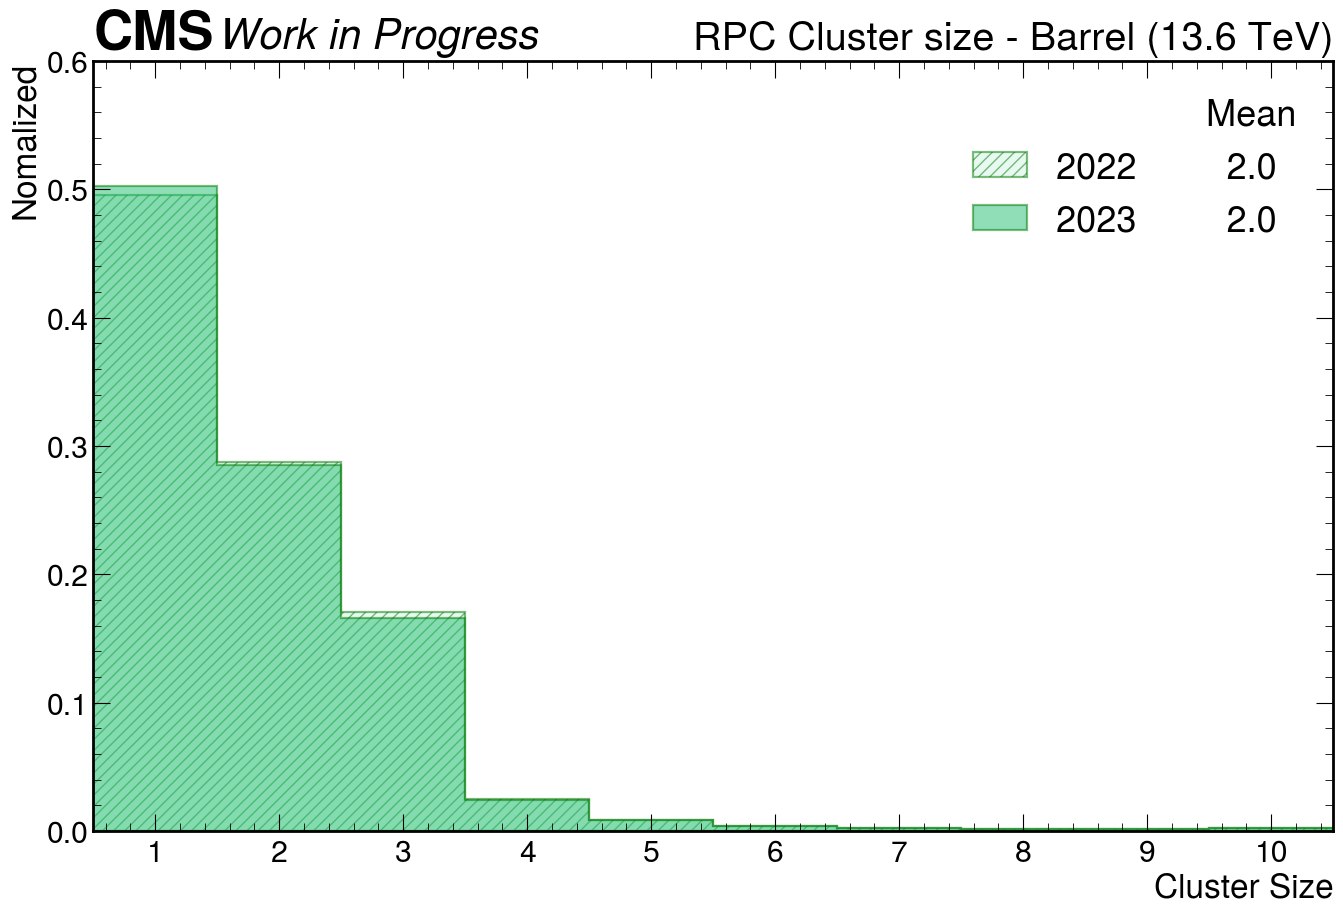

In [ ]:
mh.style.use(mh.styles.CMS)
fig, ax = plt.subplots(figsize=(16, 10))

label = "Work in Progress"
com = 13.6

mh.cms.label(ax=ax, data=True, label=label, com=com, year="RPC Cluster size - Barrel", fontsize=30)
ax.set_xlabel('Cluster Size', fontsize=24)
ax.set_ylabel('Nomalized', fontsize=24)
ax.set_xlim(0.5, 10.5)
ax.set_xticks([x for x in range(1, 11)])
ax.set_ylim(0, 0.6)
ax.plot(np.NaN, np.NaN, '-', color="None", label="               Mean")

ax = plot_cls_hist(
    data = data2022,
    ax = ax,
    facecolor= "#d3f5e4",
    edgecolor = "#007700",
    data_legend = "2022",
    region = "barrel",
    hatch = "///"
)

ax = plot_cls_hist(
    data = data2023,
    ax = ax,
    facecolor = "#21bf70",
    edgecolor = "#007700",
    data_legend = "2023",
    region = "barrel"
)

ax.legend(fontsize="26", loc='upper right')

output_dir = working_dir / 'plotting' / 'cls-hist'

if not output_dir.exists():
    output_dir.mkdir(parents=True)
    
fig.savefig(output_dir / "run3-barrel.png")